In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import PIL
from Simpsons.utils import SimpsonsDataloader
from LSUN.utils import LSUNDataloader
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook
from collections import OrderedDict
import copy
from sklearn.metrics import confusion_matrix, f1_score
import itertools
from sklearn.manifold import TSNE
import cv2
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
arch = models.resnet18(pretrained=True) 
for param in arch.parameters():
    param.requires_grad = False
    
fc  = nn.Sequential(OrderedDict([
                                ('fc1',nn.Linear(512,100,bias=True)),
                                ('batchnorm',nn.BatchNorm1d(100,eps=1e-05,momentum=0.1,affine=True)),
                                ('relu',nn.ReLU()),
                                ('dropout',nn.Dropout(p=0.25)),
                                ('fc2',nn.Linear(100,10,bias=True)),
                                ('output',nn.LogSoftmax())
                                ]))
arch.fc = fc

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
arch = arch.to(device)

In [4]:
SimpsonsPATH = "/home/kavan33_gmail_com/ActiveLearning/Data/Simpsons/Images/"
LSUNPATH = "/home/kavan33_gmail_com/ActiveLearning/Data/LSUN/LSUNSample/"
STLPATH = "/home/kavan33_gmail_com/ActiveLearning/Data/stl10_fastai/"

In [5]:
transformations = {
    'train' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
}

In [6]:
arch_hidden2 = nn.Sequential(*list(arch.children())[:-1])
arch_hidden2 = arch_hidden2.to(device)

In [7]:
train_dataset = LSUNDataloader.LSUNDataset(LSUNPATH,"train",transformations['train'])
train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
dataloader = {'train':train_dataloader}
dataset_sizes = {'train':len(train_dataset)}

In [8]:
def plotTSNE(train_dataloader,arch_hidden2):
    outputs2=[]
    labels2 = []
    for data in tqdm_notebook(train_dataloader):
        img, lab = data
        img = img.to(device)
        lab = lab.to("cpu").numpy()
        output = arch_hidden2(img)
        output = output.to("cpu").numpy()
        output = output.reshape((output.shape[0],-1))
        outputs2.extend(output)
        labels2.extend(lab)

    tsne2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tr2 = tsne2.fit_transform(outputs2)
    plt.subplots(figsize=(5,5))
    x2 = tr2[:,0]
    y2 = tr2[:,1]
    a2 = sns.scatterplot(x2,y2,hue=labels2,palette=sns.color_palette()[:len(np.unique(labels2))])
    plt.show()

## Layer 5 activations of untrained LSUN 


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.016s...
[t-SNE] Computed neighbors for 1000 samples in 1.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.674665
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.734985
[t-SNE] Error after 300 iterations: 1.687217


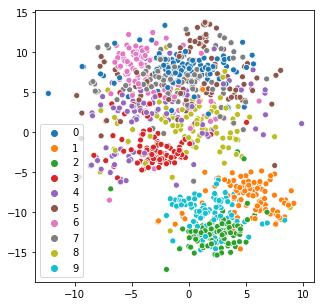

In [37]:
plotTSNE(train_dataloader,arch_hidden2)

### The classes are well seperated on pretrained Resnet, yet not trained on LSUN

In [39]:
train_dataset = SimpsonsDataloader.SimpsonsDataset(SimpsonsPATH,"train",transformations['train'])
train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
dataloader = {'train':train_dataloader}
dataset_sizes = {'train':len(train_dataset)}

## Layer 5 Activations of Untrained Simpsons 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.047s...
[t-SNE] Computed neighbors for 3000 samples in 8.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.968830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.928154
[t-SNE] Error after 300 iterations: 3.026456


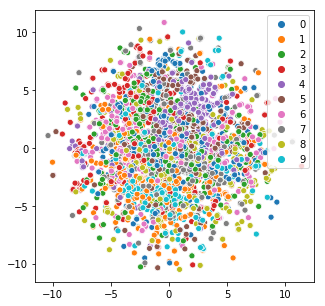

In [40]:
plotTSNE(train_dataloader,arch_hidden2)

#### We used same pretrained network to visualize layer5, but the classes are not well seperated as they were for LSUN, so capturing metadata over this will not yield good results

### In this case, we would like to deal with just 2 or 3 classes per experiment in order to capture quality metadata

In [9]:
train_dataset = SimpsonsDataloader.SimpsonsDataset(SimpsonsPATH,"train_REDUCED_FOR_ACT_VIS",transformations['train'])
train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
dataloader = {'train':train_dataloader}
dataset_sizes = {'train':len(train_dataset)}


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 886 samples in 0.015s...
[t-SNE] Computed neighbors for 886 samples in 0.928s...
[t-SNE] Computed conditional probabilities for sample 886 / 886
[t-SNE] Mean sigma: 4.419948
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.117149
[t-SNE] Error after 300 iterations: 2.019762


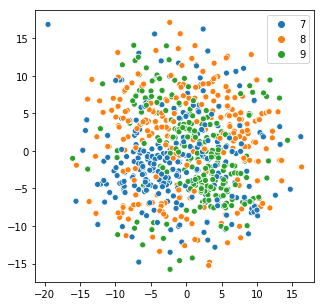

In [10]:
plotTSNE(train_dataloader,arch_hidden2)